To implement:  
- [x] Galsim shear transormation of an image  
- [ ] Shear transformation given jac matrix in tensorflow
- [ ] Jacobian computation given given shear parameters

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## GalSim transformation

In [4]:
import galsim

In [120]:
gal_flux = 1.e5    # counts
gal_r0 = 2.7       # arcsec
g1 = 0.1           #
g2 = 0.2           #
pixel_scale = 0.2  # arcsec / pixel

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=256,ny=256, scale=pixel_scale),
                               x_interpolant='linear')

# Shear the galaxy by some value.
# There are quite a few ways you can use to specify a shape.
# q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
# e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
# g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
# eta, beta    Conformal shear and position angle: eta = ln(1/q)
# e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
# g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
# eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
gal = gal.shear(g1=g1, g2=g2)

In [121]:
image_original = gal.original.drawImage(nx=256,ny=256, scale=pixel_scale, method='no_pixel').array
image_shear = gal.drawImage(nx=256,ny=256,scale=pixel_scale, method='no_pixel').array

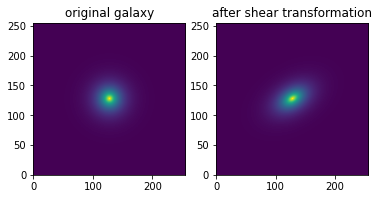

In [122]:
subplot(121)
imshow(image_original, origin='lower')
title('original galaxy')
subplot(122)
title('after shear transformation')
imshow(image_shear, origin='lower')

## Tensorflow transformation

In [123]:
import tensorflow as tf
import tensorflow_addons as tfa

In [124]:
img = tf.convert_to_tensor(image_original)

In [125]:
# get the jacobian matrix
jac = galsim.Shear(g1=g1, g2=g2).getMatrix()#.ravel().tolist()
jac = tf.cast(np.linalg.inv(jac), float32)

In [126]:
s = img.shape

In [133]:
# Coefficients of the transformation are [a0, a1, a2, b0, b1, b2, c0, c1]
# with (x', y') = ((a0 x + a1 y + a2) / k, (b0 x + b1 y + b2) / k), where k = c0 x + c1 y + 1
transform = tf.convert_to_tensor([jac[0,0], jac[0,1], ((1-jac[0,0]) - jac[0,1])*255/2, 
                                  jac[1,0], jac[1,1], ((1-jac[1,1]) - jac[1,0])*255/2,
                                  0., 0.])
# Because I'm too lazy to workout the coordinate shift corresponding to 
img2 = tfa.image.transform(img, transforms=transform, interpolation='bilinear')

Text(0.5, 1.0, 'after tfa transformation')

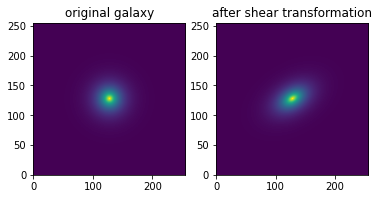

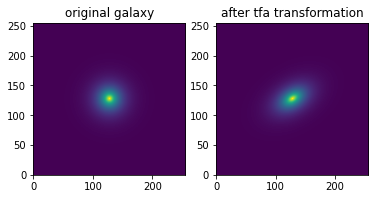

In [134]:
figure()
subplot(121)
imshow(image_original, origin='lower')
title('original galaxy')
subplot(122)
title('after shear transformation')
imshow(image_shear, origin='lower')

figure()
subplot(121)
imshow(img.numpy(), origin='lower')
title('original galaxy')
subplot(122)
imshow(img2.numpy(), origin='lower')
title('after tfa transformation')

Text(0.5, 1.0, 'Absolute difference')

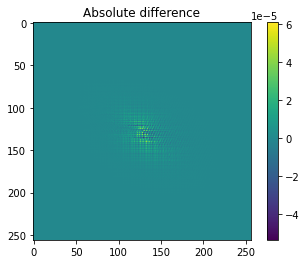

In [136]:
imshow((img2.numpy() - image_shear)); colorbar();
title('Absolute difference')